## Checking percentage of customers that are retained
In this Notebook, we create a cohort of customers based on the first month in which they placed the order. Then we check what percentage of those customers placed another order in subsequent months.

In [1]:
# Loading relevant Python packages and libraries
import pandas as pd
import os
import numpy as np
import seaborn as sns; sns.set()
sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
%matplotlib inline
from operator import attrgetter
import matplotlib.colors as mcolors
from prophet import Prophet

In [2]:
# Loading the data files we generated in the Initial_Data_Exploration Notebook
data_positive_quantity = pd.read_csv('data_positive_quantity.csv')
data_negative_quantity = pd.read_csv('data_negative_quantity.csv')
data = pd.read_csv("ecommerce_data.csv")

In [3]:
# Converting Invoice Date column to datetime format

data_positive_quantity['InvoiceDate'] =  pd.to_datetime(data_positive_quantity['InvoiceDate'], infer_datetime_format=True)

In [4]:
# Creating filtered data for unique orders by particular customers
data_filter = data_positive_quantity[['CustomerID', 'InvoiceNo', 'InvoiceDate','Estore_id','Country']].drop_duplicates()

In [5]:
# Defining a new column with order month
data_filter['order_month'] = data_filter['InvoiceDate'].dt.to_period('M')

In [6]:
# Grouping customer ID by Month in Invoice Date to create cohorts
data_filter['cohort'] = data_filter.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [7]:
# Aggregating number of unique Customers in each order month
data_filter_cohort = data_filter.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
# Creating period number using order months
data_filter_cohort['period_number'] = (data_filter_cohort.order_month - data_filter_cohort.cohort).apply(attrgetter('n'))

In [8]:
# Pivoting the data to create rows that contain information for a given cohort over a certain period

cohort_pivot = data_filter_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [9]:
# Finding the initial size of the cohort and dividing each value in the table above by the first value in the row.

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

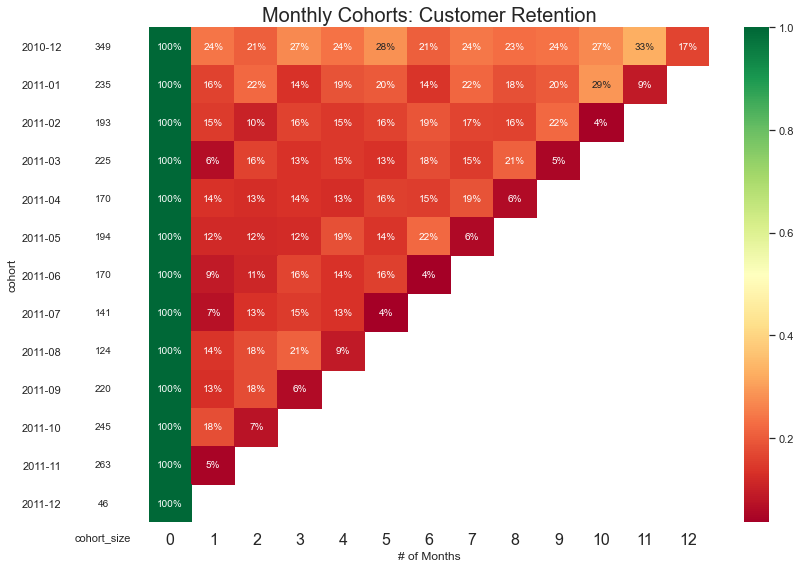

In [10]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # using seaborn to plot the retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Customer Retention', size=20)
    ax[1].set(xlabel='# of Months',
              ylabel='')
    ax[1].tick_params(axis="x", labelsize=16)
    ax[1].tick_params(axis="y", labelsize=16)

    # adding cohort size to the left of the heatmap by adding another heatmap with no colour
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

This heatmap illustrates the retention percentage of customers after they placed their first order on the GloboSales platform. Cohort size indicates the number of customers that placed their first order in the months indicated on the left.

The key takeaway from the heatmap is that customers who placed orders in high sale season (in and around December of 2010) were more likely to return to the platform throughout the year as opposed to customers who placed their orders later in the year 2011. It would be good to further investigate what was offered to the customers to order from GloboSales in December 2010 and then periodically replicate those offers/incentives throughout the year to get a higher number of return customers.

If I had more time, I would have also checked the data for return transactions and whether there was a trend with time there.